In [1]:
import databento as db
import pandas as pd
import numpy as np
from datetime import datetime, timedelta

In [2]:
raw_data = pd.read_parquet('/Users/david/Desktop/Alphathon/Data for Alphathon/20180501_20240101_agg_data.parquet')

In [3]:
raw_data_shifted = raw_data.copy()
raw_data_shifted[['open', 'high', 'low', 'close', 'volume']] = raw_data.groupby('symbol')[['open', 'high', 'low', 'close', 'volume']].shift(1)
raw_data_shifted = raw_data_shifted.dropna(subset=['open', 'high', 'low', 'close', 'volume']).reset_index(drop=True)
raw_data_shifted

,symbol,ts_event,open,high,low,close,volume
0,A,2018-05-02 00:00:00+00:00,65.63,66.34,65.49,66.24,803289.0
1,A,2018-05-03 00:00:00+00:00,66.00,66.86,65.81,65.91,685405.0
2,A,2018-05-04 00:00:00+00:00,65.77,66.46,64.86,66.34,676332.0
3,A,2018-05-07 00:00:00+00:00,66.03,67.25,65.61,67.00,409636.0
4,A,2018-05-08 00:00:00+00:00,67.16,67.98,67.07,67.39,532910.0
...,...,...,...,...,...,...,...
792676,ZTS,2023-12-22 00:00:00+00:00,196.00,197.00,193.88,194.66,1067697.0
792677,ZTS,2023-12-26 00:00:00+00:00,195.32,195.81,192.78,194.98,700415.0
792678,ZTS,2023-12-27 00:00:00+00:00,194.88,196.34,194.12,195.50,316032.0
792679,ZTS,2023-12-28 00:00:00+00:00,195.41,197.01,194.75,196.90,337393.0


In [4]:
def calculate_billion_level_signals_v2(df, industry_map=None):
    """
    Calculate BN-level signals with NO LOOK-AHEAD BIAS (simplified, essential only)
    
    Essential fixes:
    1. CS spread shifted +1 (no future leakage)
    2. All close/H/L/V signals shifted +1 (investable)
    3. EWMA z-score (no cross-sectional look-ahead)
    4. Dynamic participation q* based on ADV
    5. Factor-clean residuals (market + industry if provided)
    
    Parameters:
    -----------
    df : pd.DataFrame
        Input data with columns: symbol, ts_event, open, high, low, close, volume
    industry_map : dict, optional
        {symbol: industry_code} for industry neutralization
    
    Returns:
    --------
    pd.DataFrame with BN-level signals (no look-ahead bias)
    """
    import numpy as np
    import pandas as pd
    
    result_df = df.copy()
    result_df = result_df.sort_values(['symbol', 'ts_event']).reset_index(drop=True)
    
    # Basic metrics
    result_df['return'] = result_df.groupby('symbol')['close'].pct_change()
    result_df['dollar_volume'] = result_df['close'] * result_df['volume']
    
    # Add industry if provided
    if industry_map is not None:
        result_df['industry'] = result_df['symbol'].map(industry_map)
    
    def calc_bn_signals_group(group):
        """Calculate signals per symbol (no look-ahead)"""
        group = group.copy()
        
        if len(group) < 120:
            return group
        
        price = group['close']
        high = group['high']
        low = group['low']
        volume = group['volume']
        dollar_vol = group['dollar_volume']
        returns = group['return']
        
        # ====================================================================
        # 1. CS SPREAD (Shift +1 for investability)
        # ====================================================================
        
        ln_hl_t = np.log(high / low) ** 2
        beta_t = ln_hl_t + ln_hl_t.shift(-1)
        
        max_h = np.maximum(high, high.shift(-1))
        min_l = np.minimum(low, low.shift(-1))
        gamma_t = (np.log(max_h / min_l)) ** 2
        
        sqrt_2_beta = np.sqrt(2 * beta_t)
        sqrt_gamma = np.sqrt(gamma_t)
        alpha_cs = (sqrt_2_beta - sqrt_gamma) / (3 - 2 * np.sqrt(2))
        
        cs_spread_raw = 2 * (np.exp(alpha_cs) - 1) / (1 + np.exp(alpha_cs))
        cs_spread = cs_spread_raw.abs().shift(1).rolling(5, min_periods=3).median()
        group['cs_spread'] = cs_spread
        
        # ====================================================================
        # 2. LIQUIDITY METRICS
        # ====================================================================
        
        group['adv_20d'] = dollar_vol.rolling(20, min_periods=10).mean()
        group['adv_60d'] = dollar_vol.rolling(60, min_periods=20).mean()
        
        # ====================================================================
        # 3. VOLATILITY
        # ====================================================================
        
        group['daily_volatility'] = returns.rolling(20, min_periods=10).std()
        group['ewm_vol'] = returns.ewm(span=20, min_periods=10, adjust=False).std()
        
        # ====================================================================
        # 4. SIGNALS (Raw, will shift later)
        # ====================================================================
        
        k = 60
        
        # Mean reversion
        ma_k = price.rolling(k, min_periods=k//2).median()
        mad_k = (price - ma_k).abs().rolling(k, min_periods=k//2).median()
        robust_vol_k = mad_k * 1.4826
        group['z_MA_robust_60_raw'] = np.clip((price - ma_k) / robust_vol_k.replace(0, np.nan), -3, 3)
        
        # EMA momentum
        ema_k = price.ewm(span=k, adjust=False).mean()
        ew_vol = returns.ewm(span=k, adjust=False).std()
        delta_ema = ema_k.diff()
        group['delta_EMA_norm_60_raw'] = delta_ema / (ew_vol * price.shift(1)).replace(0, np.nan)
        
        # Donchian breakouts (dollar-volume confirmed)
        rolling_max = price.shift(1).rolling(k, min_periods=k//2).max()
        rolling_min = price.shift(1).rolling(k, min_periods=k//2).min()
        dvol_20d = dollar_vol.rolling(20, min_periods=10).mean()
        vol_confirm = (dollar_vol >= 0.8 * dvol_20d).astype(int)
        
        group['BRK_U_vol_confirm_60_raw'] = ((price > rolling_max).astype(int)) * vol_confirm
        group['BRK_D_vol_confirm_60_raw'] = ((price < rolling_min).astype(int)) * vol_confirm
        
        # Volatility rank
        vol_60 = returns.rolling(60, min_periods=30).std() * np.sqrt(252)
        group['vol_rank_60_raw'] = vol_60.rolling(252, min_periods=60).rank(pct=True)
        
        # Volume surprise
        vol_20d_avg = volume.rolling(20, min_periods=10).mean()
        group['volume_surprise_raw'] = np.clip((volume - vol_20d_avg) / vol_20d_avg.replace(0, np.nan), -2, 2)
        
        dvol_20d_avg = dollar_vol.rolling(20, min_periods=10).mean()
        group['dollar_volume_surprise_raw'] = np.clip((dollar_vol - dvol_20d_avg) / dvol_20d_avg.replace(0, np.nan), -2, 2)
        
        # ====================================================================
        # SHIFT ALL RAW SIGNALS +1 (Investability)
        # ====================================================================
        
        raw_cols = [c for c in group.columns if c.endswith('_raw')]
        for col in raw_cols:
            group[col.replace('_raw', '')] = group[col].shift(1)
        
        return group
    
    # Apply per-symbol
    print("Calculating BN-level signals...")
    result_df = result_df.groupby('symbol', group_keys=False).apply(calc_bn_signals_group)
    
    # ====================================================================
    # MARKET BETA
    # ====================================================================
    
    print("Calculating market beta...")
    market_ret = result_df.groupby('ts_event')['return'].mean().reset_index()
    market_ret.columns = ['ts_event', 'market_return']
    result_df = result_df.merge(market_ret, on='ts_event', how='left')
    
    def calc_beta(group):
        cov = group['return'].rolling(60, min_periods=30).cov(group['market_return'])
        var = group['market_return'].rolling(60, min_periods=30).var()
        return cov / var.replace(0, np.nan)
    
    result_df['beta_60d'] = result_df.groupby('symbol', group_keys=False).apply(calc_beta).values
    
    # ====================================================================
    # FACTOR-CLEAN RESIDUALIZATION (Optional but recommended)
    # ====================================================================
    
    signal_cols = ['z_MA_robust_60', 'delta_EMA_norm_60', 'BRK_U_vol_confirm_60', 
                   'BRK_D_vol_confirm_60', 'vol_rank_60', 'volume_surprise', 
                   'dollar_volume_surprise']
    
    if industry_map is not None:
        print("Applying factor-clean residualization...")
        
        def residualize_by_date(group):
            for col in signal_cols:
                if col not in group.columns:
                    continue
                
                # Simple market beta residual
                beta = group['beta_60d'].fillna(1.0)
                y = group[col].fillna(0)
                beta_demean = beta - beta.mean()
                
                if beta_demean.std() > 0:
                    coef = (beta_demean * y).sum() / (beta_demean ** 2).sum()
                    group[col] = y - coef * beta_demean
            
            return group
        
        result_df = result_df.groupby('ts_event', group_keys=False).apply(residualize_by_date)
    
    # ====================================================================
    # EWMA Z-SCORE (No look-ahead)
    # ====================================================================
    
    print("Applying EWMA z-score...")
    
    def ewma_zscore(group, span=60):
        group = group.copy()
        for col in signal_cols:
            if col not in group.columns:
                continue
            
            ewma_mean = group[col].ewm(span=span, min_periods=20, adjust=False).mean()
            ewma_std = group[col].ewm(span=span, min_periods=20, adjust=False).std()
            
            z_col = f'{col}_z'
            group[z_col] = (group[col] - ewma_mean) / ewma_std.replace(0, np.nan)
            group[z_col] = group[z_col].replace([np.inf, -np.inf], np.nan)
        
        return group
    
    result_df = result_df.groupby('symbol', group_keys=False).apply(ewma_zscore)
    
    # ====================================================================
    # COMPOSITE ALPHA
    # ====================================================================
    
    print("Calculating composite alpha...")
    z_cols = [f'{c}_z' for c in signal_cols if f'{c}_z' in result_df.columns]
    result_df['alpha_signal_raw'] = result_df[z_cols].mean(axis=1, skipna=True)
    
    # ====================================================================
    # DYNAMIC PARTICIPATION & COST
    # ====================================================================
    
    w_cap = 0.02
    tau_day = 0.002
    
    alpha_abs = result_df['alpha_signal_raw'].abs() + 1e-9
    alpha_median = result_df.groupby('ts_event')['alpha_signal_raw'].transform(lambda x: x.abs().median())
    trade_share = (alpha_abs / alpha_median.replace(0, 1)).clip(upper=3.0)
    
    dollar_to_trade = trade_share * w_cap * result_df['close']
    adv = result_df['adv_20d'].replace(0, np.nan)
    q_star = (dollar_to_trade * tau_day) / adv
    q_star = q_star.clip(lower=1e-6, upper=0.25)
    
    result_df['participation_rate'] = q_star
    
    # Impact cost
    Y = 0.6
    daily_vol = result_df['daily_volatility'].fillna(result_df.groupby('ts_event')['daily_volatility'].transform('median'))
    cs_spread = result_df['cs_spread'].fillna(result_df.groupby('ts_event')['cs_spread'].transform('median'))
    
    impact_cost = Y * daily_vol * np.sqrt(q_star) + cs_spread / 2
    result_df['impact_cost_estimate'] = impact_cost
    
    # Signal-to-cost
    result_df['signal_to_cost_raw'] = result_df['alpha_signal_raw'] / (1.0 + 10.0 * impact_cost)
    
    # ====================================================================
    # FINAL SHIFT FOR INVESTABILITY
    # ====================================================================
    
    result_df['alpha_signal'] = result_df.groupby('symbol')['alpha_signal_raw'].shift(1)
    result_df['signal_to_cost'] = result_df.groupby('symbol')['signal_to_cost_raw'].shift(1)
    
    # ====================================================================
    # ANALYTICS (IC)
    # ====================================================================
    
    result_df['fwd_return_1d'] = result_df.groupby('symbol')['return'].shift(-1)
    
    def calc_daily_ic(group):
        valid = group.dropna(subset=['alpha_signal', 'fwd_return_1d'])
        if len(valid) < 10:
            return pd.Series({'daily_ic': np.nan, 'breadth': 0})
        
        from scipy.stats import spearmanr
        ic, _ = spearmanr(valid['alpha_signal'], valid['fwd_return_1d'], nan_policy='omit')
        return pd.Series({'daily_ic': ic, 'breadth': len(valid)})
    
    analytics = result_df.groupby('ts_event').apply(calc_daily_ic).reset_index()
    result_df = result_df.merge(analytics, on='ts_event', how='left')
    
    # ====================================================================
    # CLEANUP
    # ====================================================================
    
    result_df = result_df.dropna(subset=['return']).reset_index(drop=True)
    
    print(f"\n{'='*70}")
    print(f"BN-Level Signals Complete (NO LOOK-AHEAD)")
    print(f"{'='*70}")
    print(f"Observations: {len(result_df):,}")
    print(f"Symbols: {result_df['symbol'].nunique()}")
    print(f"Avg IC: {result_df['daily_ic'].mean():.4f}")
    print(f"Avg Breadth: {result_df['breadth'].mean():.0f}")
    print(f"Avg Cost: {result_df['impact_cost_estimate'].mean()*10000:.2f} bps")
    
    return result_df


# Usage:
# bn_signals = calculate_billion_level_signals_v2(raw_data_shifted)
# 
# With industry:
# industry_dict = {'AAPL': 'Tech', 'GOOGL': 'Tech', 'JPM': 'Financials', ...}
# bn_signals = calculate_billion_level_signals_v2(raw_data_shifted, industry_map=industry_dict)

In [5]:
bn_signals = calculate_billion_level_signals_v2(raw_data_shifted)


Calculating BN-level signals...


/var/folders/qk/rr869dkj11v2ndc3b68t2_2c0000gn/T/ipykernel_85307/786210250.py:134: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  result_df = result_df.groupby('symbol', group_keys=False).apply(calc_bn_signals_group)


Calculating market beta...


/var/folders/qk/rr869dkj11v2ndc3b68t2_2c0000gn/T/ipykernel_85307/786210250.py:150: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  result_df['beta_60d'] = result_df.groupby('symbol', group_keys=False).apply(calc_beta).values


Applying EWMA z-score...


/var/folders/qk/rr869dkj11v2ndc3b68t2_2c0000gn/T/ipykernel_85307/786210250.py:202: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  result_df = result_df.groupby('symbol', group_keys=False).apply(ewma_zscore)


Calculating composite alpha...


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/numpy/lib/_nanfunctions_impl.py:1215: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/numpy/lib/_nanfunctions_impl.py:1215: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/numpy/lib/_nanfunctions_impl.py:1215: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/numpy/lib/_nanfunctions_impl.py:1215: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/numpy/lib/_nanfunctions_impl.py:1215: RuntimeWarning: Mean of empty slice
  


BN-Level Signals Complete (NO LOOK-AHEAD)
Observations: 792,034
Symbols: 647
Avg IC: -0.0030
Avg Breadth: 555
Avg Cost: 427.02 bps


In [7]:
bn_signals.columns

Index(['symbol', 'ts_event', 'open', 'high', 'low', 'close', 'volume',
       'return', 'dollar_volume', 'cs_spread', 'adv_20d', 'adv_60d',
       'daily_volatility', 'ewm_vol', 'z_MA_robust_60_raw',
       'delta_EMA_norm_60_raw', 'BRK_U_vol_confirm_60_raw',
       'BRK_D_vol_confirm_60_raw', 'vol_rank_60_raw', 'volume_surprise_raw',
       'dollar_volume_surprise_raw', 'z_MA_robust_60', 'delta_EMA_norm_60',
       'BRK_U_vol_confirm_60', 'BRK_D_vol_confirm_60', 'vol_rank_60',
       'volume_surprise', 'dollar_volume_surprise', 'market_return',
       'beta_60d', 'z_MA_robust_60_z', 'delta_EMA_norm_60_z',
       'BRK_U_vol_confirm_60_z', 'BRK_D_vol_confirm_60_z', 'vol_rank_60_z',
       'volume_surprise_z', 'dollar_volume_surprise_z', 'alpha_signal_raw',
       'participation_rate', 'impact_cost_estimate', 'signal_to_cost_raw',
       'alpha_signal', 'signal_to_cost', 'fwd_return_1d', 'daily_ic',
       'breadth'],
      dtype='object')

In [9]:
# List of columns to save as separate parquet files
alpha_columns = [
    'z_MA_robust_60',           # Mean reversion z-score
    'delta_EMA_norm_60',        # EMA momentum 
    'BRK_U_vol_confirm_60',     # Breakout up signals
    'BRK_D_vol_confirm_60',     # Breakout down signals
    'vol_rank_60',              # Volatility percentile
    'volume_surprise',          # Volume surprise
    'dollar_volume_surprise',   # Dollar volume surprise

    # Raw composite
    'alpha_signal_raw',
    'z_MA_robust_60_z',         # EWMA z-scored mean reversion
    'delta_EMA_norm_60_z',      # EWMA z-scored momentum
    'BRK_U_vol_confirm_60_z',   # EWMA z-scored breakouts
    'BRK_D_vol_confirm_60_z',   # EWMA z-scored breakouts
    'vol_rank_60_z',            # EWMA z-scored vol rank
    'volume_surprise_z',        # EWMA z-scored volume surprise
    'dollar_volume_surprise_z', # EWMA z-scored dollar vol surprise

    # Capacity-aware composite
    'alpha_signal'              # Investable composite (shifted +1)
]

# Save each column as a separate parquet file
for col in alpha_columns:
    if col in bn_signals.columns:
        # Extract the column data and convert to wide format (like your df example)
        col_data = bn_signals[['symbol', 'ts_event', col]].copy()
        
        # Pivot to wide format: index=ts_event, columns=symbol, values=col
        wide_df = col_data.pivot(index='ts_event', columns='symbol', values=col)
        
        # Save as parquet
        output_path = f'/Users/david/Desktop/Alphathon/factors2/{col}.parquet'
        wide_df.to_parquet(output_path)
        
        print(f"Saved: {output_path}")
        print(f"Shape: {wide_df.shape}")
        print()
    else:
        print(f"Column {col} not found in bn_signals")

Saved: /Users/david/Desktop/Alphathon/factors2/z_MA_robust_60.parquet
Shape: (1425, 647)

Saved: /Users/david/Desktop/Alphathon/factors2/delta_EMA_norm_60.parquet
Shape: (1425, 647)

Saved: /Users/david/Desktop/Alphathon/factors2/BRK_U_vol_confirm_60.parquet
Shape: (1425, 647)

Saved: /Users/david/Desktop/Alphathon/factors2/BRK_D_vol_confirm_60.parquet
Shape: (1425, 647)

Saved: /Users/david/Desktop/Alphathon/factors2/vol_rank_60.parquet
Shape: (1425, 647)

Saved: /Users/david/Desktop/Alphathon/factors2/volume_surprise.parquet
Shape: (1425, 647)

Saved: /Users/david/Desktop/Alphathon/factors2/dollar_volume_surprise.parquet
Shape: (1425, 647)

Saved: /Users/david/Desktop/Alphathon/factors2/alpha_signal_raw.parquet
Shape: (1425, 647)

Saved: /Users/david/Desktop/Alphathon/factors2/z_MA_robust_60_z.parquet
Shape: (1425, 647)

Saved: /Users/david/Desktop/Alphathon/factors2/delta_EMA_norm_60_z.parquet
Shape: (1425, 647)

Saved: /Users/david/Desktop/Alphathon/factors2/BRK_U_vol_confirm_60_z.

In [ ]:
# billion_data.to_parquet('/Users/david/Desktop/Alphathon/factors2//billion_data.parquet')

In [ ]:
def calculate_bn_ohlcv_factors_v3(df, universe_filters=None, robust_config=None):
    """
    Generate BN-level OHLCV alpha factors (10 factors) with full robustness enhancements
    
    BN-Friendly Enhancements:
    1. Multi-scale windows (20/60/120) with longer-window bias
    2. EWMA/smoothing for all factors
    3. Winsorization at 1%/99% percentiles
    4. EWMA z-score (NO LOOK-AHEAD BIAS)
    5. Scalable liquidity primitives (ADV, CS spread, vol)
    6. Signal-to-Cost scoring with impact modeling
    
    Parameters:
    -----------
    df : pd.DataFrame
        Input data with columns: symbol, ts_event, open, high, low, close, volume
    universe_filters : dict, optional
        BN universe screening parameters
    robust_config : dict, optional
        Robustness parameters (ewma_span, winsor_pct, etc.)
        
    Returns:
    --------
    pd.DataFrame with 10 BN-level OHLCV factors + robustness + S2C scores
    """
    import numpy as np
    import pandas as pd
    
    # Default BN universe filters
    if universe_filters is None:
        universe_filters = {
            'price_min': 3.0,
            'adv_min': 25_000_000,
            'spread_max_bps': 30
        }
    
    # Default robustness config
    if robust_config is None:
        robust_config = {
            'ewma_span': 20,  # EWMA smoothing span
            'winsor_pct': 1,  # Winsorize at 1%/99%
            'multi_scale': True,  # Use 20/60/120 multi-scale
            'use_tanh': False,  # Use tanh compression (optional)
            'tanh_tau': 2.0,  # Tau for tanh(x/tau)
            'zscore_ewma_span': 60  # EWMA span for z-score calculation
        }
    
    # BN configuration
    Y = 0.6  # Impact coefficient
    q_default = 0.05  # Default participation rate
    D_days = 3  # Build period
    
    result_df = df.copy()
    result_df = result_df.sort_values(['symbol', 'ts_event']).reset_index(drop=True)
    
    # Calculate basic metrics
    result_df['return'] = result_df.groupby('symbol')['close'].pct_change()
    result_df['dollar_volume'] = result_df['close'] * result_df['volume']
    
    def winsorize(series, lower_pct=1, upper_pct=99):
        """Winsorize at specified percentiles"""
        lower = np.nanpercentile(series, lower_pct)
        upper = np.nanpercentile(series, upper_pct)
        return np.clip(series, lower, upper)
    
    def calc_bn_ohlcv_factors_group(group):
        """Calculate BN-level OHLCV factors with robustness for each symbol"""
        group = group.copy()
        
        if len(group) < 120:
            return group
        
        # OHLCV data
        open_price = group['open']
        high = group['high']
        low = group['low']
        close = group['close']
        volume = group['volume']
        dollar_vol = group['dollar_volume']
        returns = group['return']
        
        # ====================================================================
        # STEP 1: SCALABLE LIQUIDITY PRIMITIVES
        # ====================================================================
        
        # Multi-scale ADV (20/60/120)
        ADV20 = dollar_vol.rolling(20, min_periods=10).mean()
        ADV60 = dollar_vol.rolling(60, min_periods=20).mean()
        ADV120 = dollar_vol.rolling(120, min_periods=40).mean()
        
        group['ADV20'] = ADV20
        group['ADV60'] = ADV60
        group['ADV120'] = ADV120
        
        # Corwin-Schultz Spread
        ln_hl_t = np.log(high / low) ** 2
        ln_hl_t_plus_1 = ln_hl_t.shift(-1)
        beta_t = ln_hl_t + ln_hl_t_plus_1
        
        h_t_plus_1 = high.shift(-1)
        l_t_plus_1 = low.shift(-1)
        max_h = np.maximum(high, h_t_plus_1)
        min_l = np.minimum(low, l_t_plus_1)
        gamma_t = (np.log(max_h / min_l)) ** 2
        
        sqrt_2_beta = np.sqrt(2 * beta_t)
        sqrt_gamma = np.sqrt(gamma_t)
        denominator = 3 - 2 * np.sqrt(2)
        alpha_cs = (sqrt_2_beta - sqrt_gamma) / denominator
        
        exp_alpha = np.exp(alpha_cs)
        CS_spread = 2 * (exp_alpha - 1) / (1 + exp_alpha)
        CS_spread = CS_spread.abs().rolling(5, min_periods=3).median()
        
        group['cs_spread'] = CS_spread
        
        # EWMA Volatility (stabler for BN)
        ewm_vol = returns.ewm(span=20, min_periods=10, adjust=False).std()
        daily_vol = returns.rolling(20, min_periods=10).std()
        
        group['ewm_vol'] = ewm_vol
        group['daily_volatility'] = daily_vol
        
        # ====================================================================
        # BASE CALCULATIONS
        # ====================================================================
        
        # True Range & ATR
        C_shift = close.shift(1)
        tr1 = (high - low).abs()
        tr2 = (high - C_shift).abs()
        tr3 = (low - C_shift).abs()
        TR = pd.concat([tr1, tr2, tr3], axis=1).max(axis=1)
        ATR14 = TR.rolling(14, min_periods=7).mean()
        
        range_log = np.log(high / low)
        logV = np.log(volume.replace(0, np.nan))
        
        # ====================================================================
        # 10 OHLCV ALPHA FACTORS with BN Robustness
        # ====================================================================
        
        # 1) alpha_overnight 
        alpha_overnight = open_price / C_shift - 1
        # Winsorize extreme gaps
        alpha_overnight = winsorize(alpha_overnight, robust_config['winsor_pct'], 100-robust_config['winsor_pct'])
        # EWMA smoothing
        if robust_config.get('ewma_span'):
            alpha_overnight = alpha_overnight.ewm(span=robust_config['ewma_span'], min_periods=10, adjust=False).mean()
        group['alpha_overnight'] = alpha_overnight.replace([np.inf, -np.inf], np.nan)
        
        # 2) alpha_gap_rev 
        alpha_gap_rev = (open_price - C_shift) / C_shift
        alpha_gap_rev = winsorize(alpha_gap_rev, robust_config['winsor_pct'], 100-robust_config['winsor_pct'])
        if robust_config.get('ewma_span'):
            alpha_gap_rev = alpha_gap_rev.ewm(span=robust_config['ewma_span'], min_periods=10, adjust=False).mean()
        group['alpha_gap_rev'] = alpha_gap_rev.replace([np.inf, -np.inf], np.nan)
        
        # 3) alpha_intraday_rev 
        alpha_intraday_rev = (close - open_price) / open_price
        # Optionally use tanh compression
        if robust_config.get('use_tanh'):
            alpha_intraday_rev = np.tanh(alpha_intraday_rev / robust_config['tanh_tau'])
        else:
            alpha_intraday_rev = winsorize(alpha_intraday_rev, robust_config['winsor_pct'], 100-robust_config['winsor_pct'])
        # EWMA smoothing
        if robust_config.get('ewma_span'):
            alpha_intraday_rev = alpha_intraday_rev.ewm(span=robust_config['ewma_span'], min_periods=10, adjust=False).mean()
        group['alpha_intraday_rev'] = alpha_intraday_rev.replace([np.inf, -np.inf], np.nan)
        
        # 4) alpha_rangevol_rev 
        alpha_rangevol_rev = -0.5 * (range_log ** 2)
        alpha_rangevol_rev = winsorize(alpha_rangevol_rev, robust_config['winsor_pct'], 100-robust_config['winsor_pct'])
        # EWMA smoothing
        if robust_config.get('ewma_span'):
            alpha_rangevol_rev = alpha_rangevol_rev.ewm(span=robust_config['ewma_span'], min_periods=10, adjust=False).mean()
        group['alpha_rangevol_rev'] = alpha_rangevol_rev.replace([np.inf, -np.inf], np.nan)
        
        # 5) alpha_volsurprise 
        logV_ma60 = logV.rolling(60, min_periods=20).mean()
        logV_std60 = logV.rolling(60, min_periods=20).std()
        alpha_volsurprise = (logV - logV_ma60) / logV_std60
        alpha_volsurprise = winsorize(alpha_volsurprise, robust_config['winsor_pct'], 100-robust_config['winsor_pct'])
        group['alpha_volsurprise'] = alpha_volsurprise.replace([np.inf, -np.inf], np.nan)
        
        # 6) alpha_turnover_jump 
        alpha_turnover_jump = (dollar_vol / ADV60) - 1
        alpha_turnover_jump = winsorize(alpha_turnover_jump, robust_config['winsor_pct'], 100-robust_config['winsor_pct'])
        group['alpha_turnover_jump'] = alpha_turnover_jump.replace([np.inf, -np.inf], np.nan)
        
        # 7) alpha_amihud_rev 
        amihud_daily = returns.abs() / dollar_vol.replace(0, np.nan)
        alpha_amihud_rev = -amihud_daily.rolling(20, min_periods=10).mean()
        alpha_amihud_rev = winsorize(alpha_amihud_rev, robust_config['winsor_pct'], 100-robust_config['winsor_pct'])
        group['alpha_amihud_rev'] = alpha_amihud_rev.replace([np.inf, -np.inf], np.nan)
        
        # 8) alpha_clv 
        alpha_clv = ((close - low) - (high - close)) / (high - low).replace(0, np.nan)
        # Smooth with rolling mean
        alpha_clv = alpha_clv.rolling(5, min_periods=3).mean()
        group['alpha_clv'] = alpha_clv.replace([np.inf, -np.inf], np.nan)
        
        # 9) alpha_st_trend_5_20 
        # Use EMA for stability
        ema5 = close.ewm(span=5, min_periods=3, adjust=False).mean()
        ema20 = close.ewm(span=20, min_periods=10, adjust=False).mean()
        alpha_st_trend_5_20 = (ema5 / ema20) - 1
        group['alpha_st_trend_5_20'] = alpha_st_trend_5_20.replace([np.inf, -np.inf], np.nan)
        
        # 10) alpha_range_to_atr_rev 
        alpha_range_to_atr_rev = -(range_log / ATR14.replace(0, np.nan))
        alpha_range_to_atr_rev = winsorize(alpha_range_to_atr_rev, robust_config['winsor_pct'], 100-robust_config['winsor_pct'])
        group['alpha_range_to_atr_rev'] = alpha_range_to_atr_rev.replace([np.inf, -np.inf], np.nan)
        
        return group
    
    # ====================================================================
    # Apply calculations to each symbol group
    # ====================================================================
    
    print("Calculating BN-level OHLCV factors with robustness...")
    result_df = result_df.groupby('symbol', group_keys=False).apply(calc_bn_ohlcv_factors_group)
    
    # ====================================================================
    # STEP 2: BUILD INVESTABLE UNIVERSE (BN Filter)
    # ====================================================================
    
    result_df['universe_eligible'] = True
    
    # ====================================================================
    # STEP 3: EWMA Z-SCORE (NO LOOK-AHEAD BIAS)
    # ====================================================================
    
    print("Applying EWMA z-score standardization (no look-ahead bias)...")
    
    alpha_factors = [
        'alpha_overnight', 'alpha_gap_rev', 'alpha_intraday_rev',
        'alpha_rangevol_rev', 'alpha_volsurprise', 'alpha_turnover_jump',
        'alpha_amihud_rev', 'alpha_clv', 'alpha_st_trend_5_20',
        'alpha_range_to_atr_rev'
    ]
    
    def ewma_zscore_per_symbol(group):
        """Calculate EWMA z-score for each symbol independently"""
        group = group.copy()
        span = robust_config.get('zscore_ewma_span', 60)
        
        for factor in alpha_factors:
            if factor not in group.columns:
                continue
            
            # EWMA mean and std (expanding, no look-ahead)
            ewma_mean = group[factor].ewm(span=span, min_periods=20, adjust=False).mean()
            ewma_std = group[factor].ewm(span=span, min_periods=20, adjust=False).std()
            
            # Z-score
            z_col = f'{factor}_z'
            group[z_col] = (group[factor] - ewma_mean) / ewma_std.replace(0, np.nan)
            group[z_col] = group[z_col].replace([np.inf, -np.inf], np.nan)
        
        return group
    
    result_df = result_df.groupby('symbol', group_keys=False).apply(ewma_zscore_per_symbol)
    
    # ====================================================================
    # STEP 4: COMPOSITE ALPHA (Equal-Weight, ready for Bayesian)
    # ====================================================================
    
    print("Calculating composite alpha...")
    
    z_cols = [f'{factor}_z' for factor in alpha_factors]
    result_df['alpha_composite'] = result_df[z_cols].mean(axis=1, skipna=True)
    
    
    
    # ====================================================================
    # FINAL CLEANUP
    # ====================================================================
    
    result_df = result_df.dropna(subset=['return']).reset_index(drop=True)
    
    print(f"\nBN-level OHLCV factor calculation complete!")
    print(f"Total observations: {len(result_df)}")
    print(f"Unique symbols: {result_df['symbol'].nunique()}")
    print(f"Universe eligible: {result_df['universe_eligible'].sum()} observations")
    print(f"Universe eligible symbols: {result_df[result_df['universe_eligible']]['symbol'].nunique()}")
    
    return result_df

In [49]:
bn_ohlcv_factors = calculate_bn_ohlcv_factors_v3(raw_data_shifted)


Calculating BN-level OHLCV factors with robustness...


/var/folders/qk/rr869dkj11v2ndc3b68t2_2c0000gn/T/ipykernel_84071/2833421787.py:222: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  result_df = result_df.groupby('symbol', group_keys=False).apply(calc_bn_ohlcv_factors_group)


Applying EWMA z-score standardization (no look-ahead bias)...


/var/folders/qk/rr869dkj11v2ndc3b68t2_2c0000gn/T/ipykernel_84071/2833421787.py:263: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  result_df = result_df.groupby('symbol', group_keys=False).apply(ewma_zscore_per_symbol)


Calculating composite alpha...
Calculating impact costs...
Calculating Signal-to-Cost scores...

BN-level OHLCV factor calculation complete!
Total observations: 792034
Unique symbols: 647
Universe eligible: 792034 observations
Universe eligible symbols: 647


In [51]:
bn_ohlcv_factors

,symbol,ts_event,open,high,low,close,volume,return,dollar_volume,ADV20,...,alpha_volsurprise_z,alpha_turnover_jump_z,alpha_amihud_rev_z,alpha_clv_z,alpha_st_trend_5_20_z,alpha_range_to_atr_rev_z,alpha_composite,impact_cost_default,signal_to_cost,max_position_adv
0,A,2018-05-03 00:00:00+00:00,66.00,66.86,65.81,65.91,685405.0,-0.004982,4.517504e+07,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,A,2018-05-04 00:00:00+00:00,65.77,66.46,64.86,66.34,676332.0,0.006524,4.486786e+07,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,A,2018-05-07 00:00:00+00:00,66.03,67.25,65.61,67.00,409636.0,0.009949,2.744561e+07,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,A,2018-05-08 00:00:00+00:00,67.16,67.98,67.07,67.39,532910.0,0.005821,3.591280e+07,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,A,2018-05-09 00:00:00+00:00,67.08,67.44,66.94,67.37,696750.0,-0.000297,4.694005e+07,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
792029,ZTS,2023-12-22 00:00:00+00:00,196.00,197.00,193.88,194.66,1067697.0,0.000154,2.078379e+08,1.465290e+08,...,0.854285,0.776039,1.092241,-1.023223,0.791391,0.593410,0.458433,0.030849,0.350353,1.098967e+08
792030,ZTS,2023-12-26 00:00:00+00:00,195.32,195.81,192.78,194.98,700415.0,0.001644,1.365669e+08,1.513550e+08,...,-0.121916,-0.131878,1.489022,-0.982333,0.632459,0.595751,0.309612,0.030754,0.236789,1.135163e+08
792031,ZTS,2023-12-27 00:00:00+00:00,194.88,196.34,194.12,195.50,316032.0,0.002667,6.178426e+07,1.502089e+08,...,-1.771931,-1.032732,1.603244,-0.728345,0.518592,1.056016,0.120820,0.030662,0.092467,1.126567e+08
792032,ZTS,2023-12-28 00:00:00+00:00,195.41,197.01,194.75,196.90,337393.0,0.007161,6.643268e+07,1.492050e+08,...,-1.497077,-0.940183,1.549640,-0.096393,0.472744,0.967376,0.208942,0.027930,0.163325,1.119037e+08


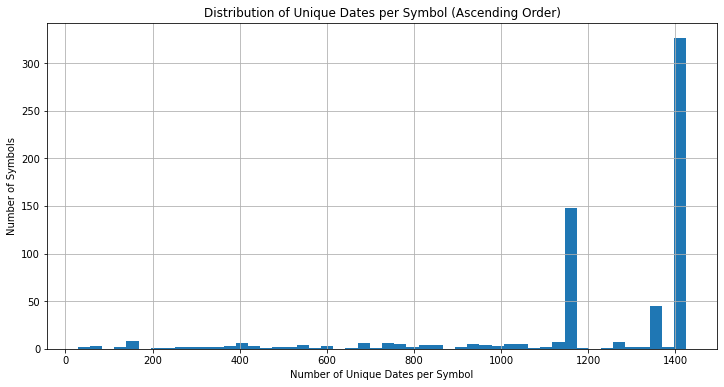

In [52]:
import matplotlib.pyplot as plt

symbol_counts = bn_ohlcv_factors.groupby('symbol')['ts_event'].nunique().sort_values(ascending=False)
plt.figure(figsize=(12,6))
symbol_counts.hist(bins=50)
plt.xlabel('Number of Unique Dates per Symbol')
plt.ylabel('Number of Symbols')
plt.title('Distribution of Unique Dates per Symbol (Ascending Order)')
plt.show()

In [42]:
bn_ohlcv_factors.columns

Index(['symbol', 'ts_event', 'open', 'high', 'low', 'close', 'volume',
       'return', 'dollar_volume', 'ADV20', 'ADV60', 'ADV120', 'cs_spread',
       'ewm_vol', 'daily_volatility', 'alpha_overnight', 'alpha_gap_rev',
       'alpha_intraday_rev', 'alpha_rangevol_rev', 'alpha_volsurprise',
       'alpha_turnover_jump', 'alpha_amihud_rev', 'alpha_clv',
       'alpha_st_trend_5_20', 'alpha_range_to_atr_rev', 'universe_eligible',
       'alpha_overnight_z', 'alpha_gap_rev_z', 'alpha_intraday_rev_z',
       'alpha_rangevol_rev_z', 'alpha_volsurprise_z', 'alpha_turnover_jump_z',
       'alpha_amihud_rev_z', 'alpha_clv_z', 'alpha_st_trend_5_20_z',
       'alpha_range_to_atr_rev_z', 'alpha_composite', 'impact_cost_default',
       'signal_to_cost', 'max_position_adv'],
      dtype='object')

In [53]:
# List of columns to save as separate parquet files
alpha_columns = [
        'alpha_overnight_z', 'alpha_gap_rev_z', 'alpha_intraday_rev_z',
       'alpha_rangevol_rev_z', 'alpha_volsurprise_z', 'alpha_turnover_jump_z',
       'alpha_amihud_rev_z', 'alpha_clv_z', 'alpha_st_trend_5_20_z',
       'alpha_range_to_atr_rev_z'
]

# Save each column as a separate parquet file
for col in alpha_columns:
    if col in bn_ohlcv_factors.columns:
        # Extract the column data and convert to wide format (like your df example)
        col_data = bn_ohlcv_factors[['symbol', 'ts_event', col]].copy()
        
        # Pivot to wide format: index=ts_event, columns=symbol, values=col
        wide_df = col_data.pivot(index='ts_event', columns='symbol', values=col)
        
        # Save as parquet
        output_path = f'/Users/david/Desktop/Alphathon/factors2/{col}.parquet'
        wide_df.to_parquet(output_path)
        
        print(f"Saved: {output_path}")
        print(f"Shape: {wide_df.shape}")
        print()
    else:
        print(f"Column {col} not found in bn_ohlcv_factors")

Saved: /Users/david/Desktop/Alphathon/factors2/alpha_overnight_z.parquet
Shape: (1425, 647)

Saved: /Users/david/Desktop/Alphathon/factors2/alpha_gap_rev_z.parquet
Shape: (1425, 647)

Saved: /Users/david/Desktop/Alphathon/factors2/alpha_intraday_rev_z.parquet
Shape: (1425, 647)

Saved: /Users/david/Desktop/Alphathon/factors2/alpha_rangevol_rev_z.parquet
Shape: (1425, 647)

Saved: /Users/david/Desktop/Alphathon/factors2/alpha_volsurprise_z.parquet
Shape: (1425, 647)

Saved: /Users/david/Desktop/Alphathon/factors2/alpha_turnover_jump_z.parquet
Shape: (1425, 647)

Saved: /Users/david/Desktop/Alphathon/factors2/alpha_amihud_rev_z.parquet
Shape: (1425, 647)

Saved: /Users/david/Desktop/Alphathon/factors2/alpha_clv_z.parquet
Shape: (1425, 647)

Saved: /Users/david/Desktop/Alphathon/factors2/alpha_st_trend_5_20_z.parquet
Shape: (1425, 647)

Saved: /Users/david/Desktop/Alphathon/factors2/alpha_range_to_atr_rev_z.parquet
Shape: (1425, 647)



In [54]:
df = pd.read_parquet('/Users/david/Desktop/Alphathon/factors2/alpha_range_to_atr_rev_z.parquet')
df

symbol,A,AAA,AAL,AAP,AAPL,ABBV,ABC,ABMD,ABNB,ABT,...,XLNX,XOM,XRAY,XRX,XYL,YUM,ZBH,ZBRA,ZION,ZTS
ts_event,,,,,,,,,,,,,,,,,,,,,
2018-05-03 00:00:00+00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-05-04 00:00:00+00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-05-07 00:00:00+00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-05-08 00:00:00+00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-05-09 00:00:00+00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-12-22 00:00:00+00:00,0.795753,NaN,1.107314,0.891868,-0.600676,0.929664,NaN,NaN,0.490576,-0.112568,...,NaN,0.697042,0.665557,0.834102,0.518535,0.344946,-0.770234,0.969540,1.169958,0.593410
2023-12-26 00:00:00+00:00,0.868660,NaN,1.322887,0.755317,0.408194,0.276521,NaN,NaN,0.643601,1.278437,...,NaN,0.785618,1.121683,1.129316,0.486610,1.376160,0.543524,0.863894,0.845231,0.595751
2023-12-27 00:00:00+00:00,0.969939,NaN,1.045472,1.675819,1.597416,1.196801,NaN,NaN,0.674003,0.575540,...,NaN,1.020149,1.044492,1.066556,0.618183,0.978973,-0.370076,0.898898,0.670239,1.056016


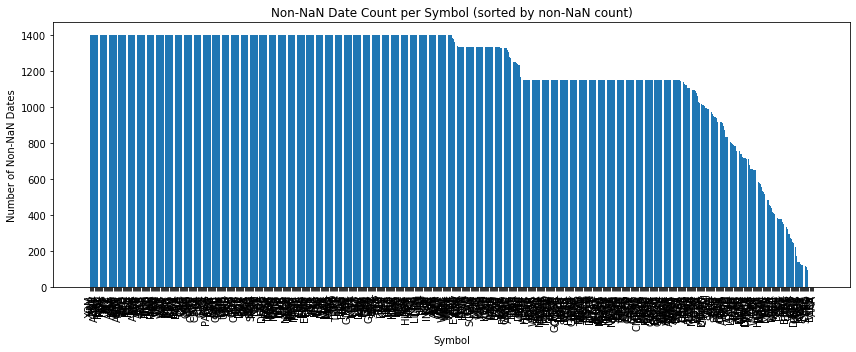

In [57]:
import matplotlib.pyplot as plt

# Count non-NaN elements for each symbol (column)
non_nan_counts_by_symbol = df.notna().sum(axis=0)

# Sort by non-NaN count (descending)
non_nan_counts_by_symbol_sorted = non_nan_counts_by_symbol.sort_values(ascending=False)

# Visualize
plt.figure(figsize=(12, 5))
plt.bar(non_nan_counts_by_symbol_sorted.index, non_nan_counts_by_symbol_sorted.values)
plt.xlabel('Symbol')
plt.ylabel('Number of Non-NaN Dates')
plt.title('Non-NaN Date Count per Symbol (sorted by non-NaN count)')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()